In [2]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import rpy2
%load_ext rpy2.ipython
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
mpl.rcParams['pdf.fonttype'] = 42

## CHASMplus comparison to PTEN saturation mutagenesis


In [3]:
# read data
chasmplus_df = pd.read_table('CHASMplus/data/PTEN/pten_saturation_mutagenesis.chasm2_output.txt')
phosphatase = pd.read_table('CHASMplus/data/PTEN/pten_saturation_mutagenesis.txt')
abundance = pd.read_table('CHASMplus/data/PTEN/Matreyek_et_al_pten_abundance.txt')

In [4]:
# format phophatase df
phosphatase['UID'] = range(len(phosphatase))
phosphatase = phosphatase.rename(columns={'Cum_score': 'lipid phosphatase activity'})

# format CHASMplus data
pten_driver_gene_score = 0.969
chasmplus_df['gwCHASMplus'] = chasmplus_df['driver'] * pten_driver_gene_score

# merge results
df = pd.merge(phosphatase, chasmplus_df[['UID', 'gwCHASMplus']], on='UID', how='left')
rename_dict = {
    'variant': 'Variant (one letter)',
    'score': 'protein abundance'
}
abundance = abundance.rename(columns=rename_dict)
mycols = ['Variant (one letter)', 'abundance_class', 'protein abundance']
df = pd.merge(df, abundance, on=mycols[0], how='left')

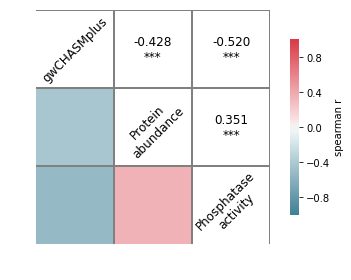

In [5]:
# initialize figure/axis
fig, ax = plt.subplots()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
rename_dict = {'driver': 'CHASMplus', 
               'protein abundance': 'Protein\nabundance', 
               'lipid phosphatase activity': 'Phosphatase\nactivity'}
columns = ['gwCHASMplus', 'protein abundance', 'lipid phosphatase activity']
corr = df[columns].rename(columns=rename_dict).corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# make heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1.0, vmin=-1.0,
            square=True, linewidths=.25, linecolor='gray', 
            cbar_kws={"shrink": .75, 'label': 'spearman r'}, 
            ax=ax)

# add correlation numbers
for i in range(len(corr)):
    ax.text(i+0.5, (i+0.5), corr.columns[i], 
            ha="center", va="center", rotation=45, fontsize=12)
    for j in range(i+1, len(corr)):
        # figure out significance
        not_null = (~df[columns[i]].isnull()) & (~df[columns[j]].isnull())
        pval = stats.spearmanr(df.loc[not_null, columns[i]], df.loc[not_null, columns[j]])[1]
        mytext = 'ns'
        if pval <= 0.05: mytext = '*'
        if pval <= 0.01: mytext += '*'
        if pval <= 0.001: mytext += '*'
        
        # add text
        s = "{0:.3f}\n{1}".format(corr.values[i,j], mytext)
        ax.text(j+0.5,(i+0.5),s, 
                ha="center", va="center", fontsize=12)

# remove axes ticks
ax.axis('off')
plt.tight_layout()

# save results
plt.savefig('CHASMplus/figures/figure_5d.pdf')

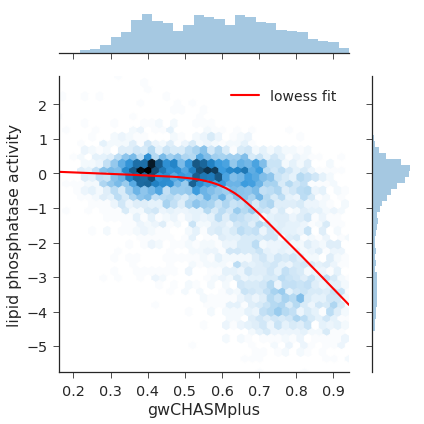

In [6]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.8):
    g = sns.jointplot('gwCHASMplus', 'lipid phosphatase activity', 
                      data=df, kind='hex')
    sns.regplot('gwCHASMplus', 'lipid phosphatase activity', data=df, lowess=True, 
                ax=g.ax_joint, color='red', scatter=False, label='lowess fit')
    g.ax_joint.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5b.pdf')

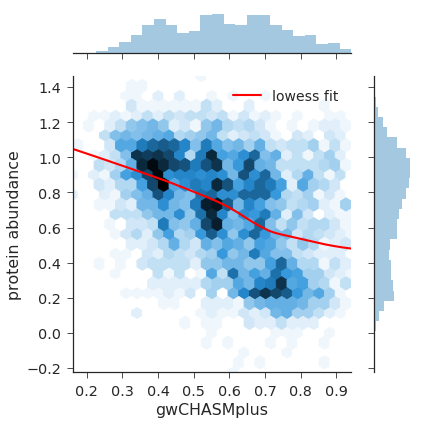

In [7]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.8):
    g = sns.jointplot('gwCHASMplus', 'protein abundance', 
                      data=df, kind='hex')
    sns.regplot('gwCHASMplus', 'protein abundance', data=df, lowess=True, 
                ax=g.ax_joint, color='red', scatter=False, label='lowess fit')
    g.ax_joint.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5c.pdf')

### Plot in silico saturation mutagenesis

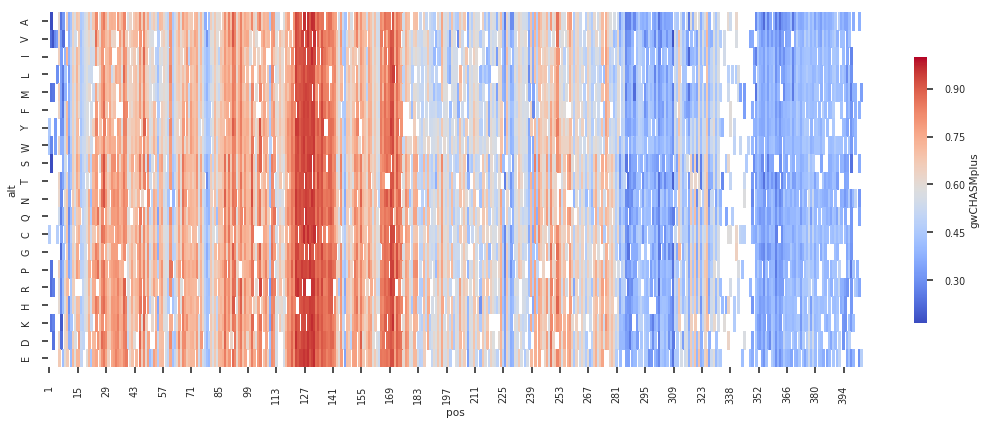

In [8]:
ref = chasmplus_df.ID.str.extract('_([A-Z])[0-9]+', expand=False)
pos = chasmplus_df.ID.str.extract('_[A-Z]([0-9]+)[A-Z]', expand=False).astype(int)
alt = chasmplus_df.ID.str.extract('_[A-Z][0-9]+([A-Z])', expand=False)
plot_df = chasmplus_df.copy()
plot_df['ref'] = ref
plot_df['alt'] = alt
plot_df['pos'] = pos
aa_order = ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'R', 'H', 'K', 'D', 'E']
tmp = pd.pivot_table(plot_df, values='driver', index='alt', columns='pos')
tmp = tmp.loc[aa_order]

with sns.plotting_context('poster', font_scale=.6), sns.axes_style('ticks'):
    fig, ax = plt.subplots()
    mask = tmp.isnull()
    #sns.color_palette("coolwarm", 7)
    sns.heatmap(tmp, mask=mask, square=False, 
                cbar_kws={'shrink':.75, 'label': 'gwCHASMplus',}, vmax=1,
                cmap="coolwarm", 
                ax=ax)
    fig.set_size_inches(15, 6)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5a.pdf')

### Examine characteristics of rare variants

In [9]:
rare_df = pd.read_table('CHASMplus/data/rarity_analysis/PANCAN.txt')
result_df = utils.read_result('PANCAN')

# read in truncating variants
other_var_df = pd.read_table('CHASMplus/data/pten/pten_saturation_mutagenesis_full.txt')
is_other_var = other_var_df['Type'].isin(['aa_del', 'nonsense'])
is_high_conf = other_var_df['High_conf']
other_var_df = other_var_df[(is_other_var & is_high_conf)].copy()
other_var_df['HGVSp_Short'] = 'p.' + other_var_df['Variant (one letter)']
other_var_df.loc[other_var_df['Type'].isin(['aa_del', 'nonsense',]), 'category'] = 'lof'
#other_var_df['abundance'] = np.nan
other_var_df = other_var_df.rename(columns={'Cum_score': 'lipid phosphatase activity'})

# merge in lof variants from abundance assay
tmp_abundance = abundance[abundance['class']=='nonsense'].copy()
tmp_abundance.loc[:,'Variant (one letter)'] = tmp_abundance['Variant (one letter)'].str[:-1] + '*'
mycols = ['Variant (one letter)', 'protein abundance']
other_var_df = pd.merge(other_var_df, tmp_abundance[mycols], on=mycols[0], how='left')

In [10]:
tmp = result_df[(result_df['Hugo_Symbol']=='PTEN') & (result_df['PANCAN']<=0.01)].drop_duplicates('HGVSp_Short')
tmp['mutation'] = tmp['Hugo_Symbol'] + '_' + tmp['Transcript_ID'] + '_' + tmp['Protein_position']
tmp = pd.merge(tmp, rare_df[['mutation', 'category']], on='mutation', how='left')
mycols = ['HGVSp_Short', 'Type', 'protein abundance', 'lipid phosphatase activity']
tmp2 = pd.merge(df[mycols], tmp[['HGVSp_Short', 'category']], on='HGVSp_Short', how='left')

In [11]:
tmp2 = pd.concat([tmp2, other_var_df[mycols+['category']]])
tmp2['category'] = tmp2['category'].fillna('all other missense')

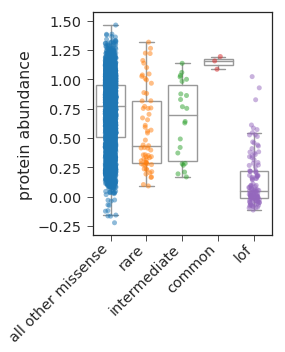

In [12]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots()
    sns.boxplot('category', 'protein abundance', data=tmp2, color='white', ax=ax, fliersize=0)
    sns.stripplot('category', 'protein abundance', data=tmp2, jitter=.15, alpha=.5, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', which='major', pad=0)
    plt.xlabel('')
    fig.set_size_inches(4, 5)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5f.pdf')

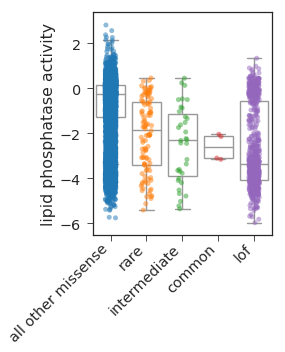

In [13]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots()
    sns.boxplot('category', 'lipid phosphatase activity', data=tmp2, color='white', ax=ax, fliersize=0)
    sns.stripplot('category', 'lipid phosphatase activity', data=tmp2, jitter=.15, ax=ax, alpha=.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', which='major', pad=0)
    plt.xlabel('')
    fig.set_size_inches(4, 5)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5e.pdf')

In [14]:
def mannwhitney_test(data):
    """Perform a mann-whitney u test on all columns of interest"""
    comparisons = ['rare', 'intermediate', 'common', 'lof']
    output = [['variable', 'rare p-value', 'intermediate p-value', 'common p-value', 'lof p-value']]
    for col in ['protein abundance', 'lipid phosphatase activity']:
        tmp_output = [col]
        for item in comparisons:
            other_mis = data[data['category']=='all other missense'][col].dropna()
            alt = data[data['category']==item][col].dropna()
            pvalue = stats.mannwhitneyu(other_mis, alt).pvalue
            tmp_output.append(pvalue)
        output.append(tmp_output)
    test_result_df = pd.DataFrame(output[1:], columns=output[0])
    return test_result_df

In [15]:
mannwhitney_test(tmp2)

,variable,rare p-value,intermediate p-value,common p-value,lof p-value
0,protein abundance,9.251990e-05,1.695218e-01,0.003617,5.052265e-59
1,lipid phosphatase activity,1.561478e-18,1.937234e-09,0.007993,1.577426e-112


In [16]:
# save supplementary table
supp_table = pd.merge(tmp2, df[['HGVSp_Short', 'gwCHASMplus']], on='HGVSp_Short', how='left')
supp_table.to_csv('CHASMplus/results/table_S5.txt', sep='\t', index=False)